In [1]:
# @title 1. Mount Google Drive and Import Libraries

from google.colab import drive
import os
import re # Regular expressions for parsing filenames
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm # Progress bar

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please ensure you authorize access when prompted.")
    # Stop execution if mounting fails
    raise ConnectionError("Failed to mount Google Drive.")

print("-" * 30)
print("Libraries imported and Drive mounted.")

Mounted at /content/drive
Google Drive mounted successfully.
------------------------------
Libraries imported and Drive mounted.


In [2]:
# @title 2. Configuration: Set Path to Dataset Folder in Drive

# --- IMPORTANT: SET THIS PATH ---
# Change this to the exact path of your dataset folder within Google Drive
# Example: If your folder 'Celeb-FBI-Images' is directly in 'My Drive',
#          the path would be '/content/drive/MyDrive/Celeb-FBI-Images'
# Example: If it's inside a folder called 'Datasets', it might be
#          '/content/drive/MyDrive/Datasets/Celeb-FBI-Images'

dataset_folder_path = "/content/drive/MyDrive/Demographics"  # <--- CHANGE THIS

# --- Verification ---
if os.path.exists(dataset_folder_path) and os.path.isdir(dataset_folder_path):
    print(f"Dataset folder found at: {dataset_folder_path}")
    # Optional: List first few items to confirm
    try:
        print("First few items in the folder:")
        print(os.listdir(dataset_folder_path)[:10])
    except Exception as e:
        print(f"Could not list directory contents: {e}")
else:
    print(f"ERROR: Dataset folder not found at '{dataset_folder_path}'")
    print("Please verify the path you entered above is correct and the folder exists in your Google Drive.")
    # Stop execution if path is invalid
    raise FileNotFoundError(f"Dataset folder not found: {dataset_folder_path}")

print("-" * 30)

Dataset folder found at: /content/drive/MyDrive/Demographics
First few items in the folder:
['8375_5.3h_53w_female_45a.png', '8390_5.9h_67w_female_33a.jpg', '837_5.5h_57w_female_61a.png', '8381_5.5h_55w_female_44a.jpg', '8383_5.3h_78w_male_43a.png', '8396_6h_78w_male_38a.jpg', '8392_0h_0w_female_43a.png', '8377_6.1h_78w_male_51a.jpg', '8397_6.1h_73w_male_40a.png', '8379_5.3h_53w_male_26a.jpg']
------------------------------


In [3]:
# @title 3. Define Filename Parsing Functions

def parse_height(height_str):
    """Parses height like '5.5h' (5 feet 5 inches) into total inches."""
    try:
        # Remove 'h'
        height_val = height_str[:-1]
        # Split '5.5' into '5' and '5'
        parts = height_val.split('.')
        if len(parts) == 2:
            feet = int(parts[0])
            inches_part = parts[1]
            # Handle cases like '5.10h' -> inches = 10, or '5.5h' -> inches = 5
            inches = int(inches_part)
            total_inches = (feet * 12) + inches
            return total_inches
        elif len(parts) == 1: # Handle case like '6h' (assuming 6 feet 0 inches)
             feet = int(parts[0])
             return feet * 12
        else:
            return None # Invalid format
    except ValueError:
        return None # Error during conversion

def parse_filename(filename):
    """Parses filename like '1021_5.5h_51w_female_26a.png'"""
    # Regex to capture the parts:
    pattern = re.compile(r"(\d+)_([\d.]+h)_(\d+w)_(male|female)_(\d+a)\.(png|jpg|jpeg)", re.IGNORECASE)
    match = pattern.match(filename)

    if match:
        serial, height_str, weight_str, gender, age_str, _ext = match.groups()

        try:
            # Parse height (e.g., '5.5h' -> 65 inches)
            height_inches = parse_height(height_str)

            # Parse weight (e.g., '51w' -> 51)
            weight_kg = int(weight_str[:-1])

            # Parse age (e.g., '26a' -> 26)
            age_years = int(age_str[:-1])

            if height_inches is None: # Check if height parsing failed
                 # print(f"Warning: Could not parse height '{height_str}' in filename: {filename}")
                 return None

            return {
                "filename": filename,
                "serial_no": int(serial),
                "height_str": height_str,
                "height_inches": height_inches,
                "weight_str": weight_str,
                "weight_kg": weight_kg,
                "gender": gender.lower(),
                "age_str": age_str,
                "age_years": age_years
            }
        except ValueError as e:
            # print(f"Warning: Error converting values for {filename}: {e}")
            return None
    else:
        # print(f"Warning: Filename '{filename}' did not match expected format.")
        return None

print("Parsing functions defined.")
print("-" * 30)

Parsing functions defined.
------------------------------


In [4]:
# @title 4. Process Files from Drive and Create DataFrame

parsed_data = []
skipped_count = 0
df = pd.DataFrame() # Initialize DataFrame

if dataset_folder_path and os.path.exists(dataset_folder_path):
    print(f"Scanning image files in: {dataset_folder_path}")
    try:
        all_files = os.listdir(dataset_folder_path)
        image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(os.path.join(dataset_folder_path, f))]
        print(f"Found {len(image_files)} potential image files.")

        if not image_files:
             print("No image files (.png, .jpg, .jpeg) found in the specified directory.")
        else:
            for fname in tqdm(image_files, desc="Parsing filenames"):
                data = parse_filename(fname)
                if data:
                    # Add the full path to the image file in Drive
                    data['filepath'] = os.path.join(dataset_folder_path, fname)
                    parsed_data.append(data)
                else:
                    skipped_count += 1

            print(f"\nSuccessfully parsed {len(parsed_data)} filenames.")
            if skipped_count > 0:
                print(f"Skipped {skipped_count} files due to format mismatch or parsing errors.")

            # Create DataFrame
            if parsed_data:
                df = pd.DataFrame(parsed_data)
                print("\nDataFrame created successfully.")
            else:
                # df remains an empty DataFrame initialized earlier
                print("\nNo data parsed, DataFrame is empty.")

    except Exception as e:
        print(f"An error occurred while listing or processing files: {e}")

else:
    # This case should have been caught in Cell 2, but double-checking
    print("ERROR: Dataset folder path not found or not set correctly. Cannot parse filenames.")


# Display info about the DataFrame
if not df.empty:
    print("\n--- Parsed Dataframe Info ---")
    print(df.info())
    print("\n--- First 5 Rows ---")
    print(df.head())
    print("\n--- Descriptive Statistics ---")
    # Select only numerical columns for describe()
    print(df[['serial_no', 'height_inches', 'weight_kg', 'age_years']].describe())
    print("\n--- Gender Distribution ---")
    print(df['gender'].value_counts())
else:
    print("\nDataFrame is empty, cannot display info.")

print("-" * 30)

Scanning image files in: /content/drive/MyDrive/Demographics
Found 7211 potential image files.


Parsing filenames:   0%|          | 0/7211 [00:00<?, ?it/s]


Successfully parsed 7196 filenames.
Skipped 15 files due to format mismatch or parsing errors.

DataFrame created successfully.

--- Parsed Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7196 entries, 0 to 7195
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   filename       7196 non-null   object
 1   serial_no      7196 non-null   int64 
 2   height_str     7196 non-null   object
 3   height_inches  7196 non-null   int64 
 4   weight_str     7196 non-null   object
 5   weight_kg      7196 non-null   int64 
 6   gender         7196 non-null   object
 7   age_str        7196 non-null   object
 8   age_years      7196 non-null   int64 
 9   filepath       7196 non-null   object
dtypes: int64(4), object(6)
memory usage: 562.3+ KB
None

--- First 5 Rows ---
                       filename  serial_no height_str  height_inches  \
0  8375_5.3h_53w_female_45a.png       8375       5.3h             

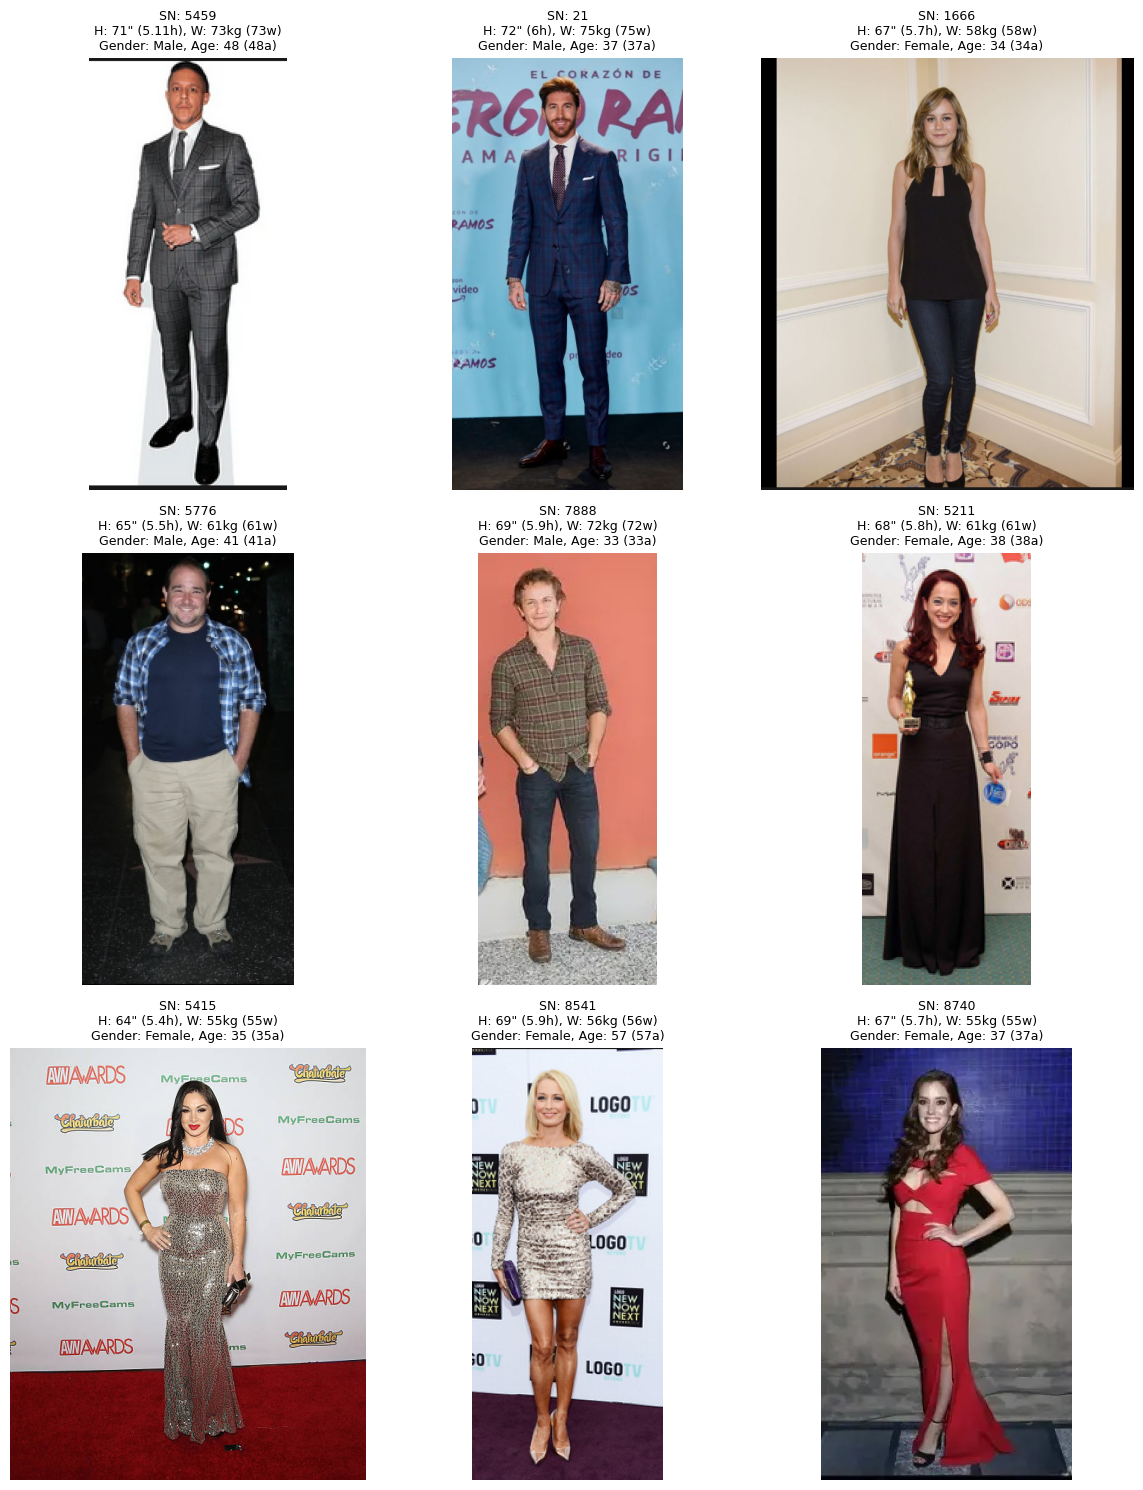

------------------------------
Script Finished.


In [5]:
# @title 5. Display Sample Images with Parsed Attributes

num_images_to_display = 9 # How many images to show

if not df.empty and 'filepath' in df.columns:
    if len(df) == 0:
        print("DataFrame is empty, no images to display.")
    elif len(df) < num_images_to_display:
        print(f"Warning: Only {len(df)} images available, displaying all.")
        sample_df = df
    else:
        sample_df = df.sample(num_images_to_display, random_state=42) # Use random_state for reproducibility if needed

    # Calculate grid size
    cols = int(num_images_to_display**0.5)
    if cols == 0: cols = 1 # Avoid division by zero if only 1 image
    rows = (num_images_to_display + cols - 1) // cols

    plt.figure(figsize=(cols * 4, rows * 5)) # Adjust figure size

    display_count = 0
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = row['filepath']
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path)

                # Create title string from parsed data
                title = (f"SN: {row['serial_no']}\n"
                         f"H: {row['height_inches']}\" ({row['height_str']}), "
                         f"W: {row['weight_kg']}kg ({row['weight_str']})\n"
                         f"Gender: {row['gender'].capitalize()}, "
                         f"Age: {row['age_years']} ({row['age_str']})")

                plt.subplot(rows, cols, i + 1)
                plt.imshow(img)
                plt.title(title, fontsize=9)
                plt.axis('off')
                display_count += 1
            except Exception as e:
                print(f"Error loading/displaying image {img_path}: {e}")
        else:
            print(f"Image file not found at path: {img_path} (This might indicate an issue with the path stored in the DataFrame)")

    if display_count > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("No images were successfully displayed.")


elif df.empty:
    print("Cannot display images: DataFrame is empty.")
else:
    print("Cannot display images: 'filepath' column missing or other issue.")

print("-" * 30)
print("Script Finished.")

In [6]:
# @title 6. Import TensorFlow/Keras and Prepare Multi-Output Data

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.applications import ResNet50 # Example pre-trained model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input # Preprocessing specific to ResNet50

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# No longer need classification_report/confusion_matrix here, moved to evaluation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Progress bar for evaluation step

# --- Configuration ---
# Define all target columns we want to predict
TARGET_COLUMNS = {
    # Output Name : Task Type
    'gender': 'classification', # Task type for gender
    'age': 'regression',        # Task type for age
    'height': 'regression',     # Task type for height
    'weight': 'regression'      # Task type for weight
}
GENDER_TARGET_COL = 'gender' # Specific column name in df for gender encoding/stratification

# Mapping from desired output name (dict key) to the actual column name in the dataframe
# Adjust these if your dataframe columns from Cell 4 parsing are different
LABEL_COLUMN_MAP = {
    'gender': 'gender',      # Will be label encoded later
    'age': 'age_years',
    'height': 'height_inches',
    'weight': 'weight_kg'
}


IMG_SIZE = (224, 224) # Input size expected by ResNet50
BATCH_SIZE = 32
RANDOM_SEED = 42 # for reproducibility

# --- Ensure DataFrame exists and has necessary columns ---
if 'df' not in globals() or df.empty:
    print("ERROR: DataFrame 'df' not found or is empty. Please run the previous cells first.")
    raise NameError("DataFrame 'df' is not defined or empty.")

# Check for filepath and all source columns needed for labels
required_source_cols = ['filepath'] + list(LABEL_COLUMN_MAP.values())
missing_cols = [col for col in required_source_cols if col not in df.columns]
if missing_cols:
     print(f"ERROR: DataFrame is missing required source columns: {missing_cols}")
     print("Please check the parsing logic in Cell 3 & 4 or the LABEL_COLUMN_MAP.")
     raise KeyError(f"Missing source columns: {missing_cols}")
else:
     print("All required source columns found in DataFrame.")


# --- Data Preprocessing ---
# 1. Handle Labels (Encode gender, keep others numerical)
label_encoder = LabelEncoder()
# Create a new column for the encoded gender label
encoded_gender_col = 'gender_encoded'
df[encoded_gender_col] = label_encoder.fit_transform(df[LABEL_COLUMN_MAP[GENDER_TARGET_COL]])
class_names = list(label_encoder.classes_) # Store class names ('female', 'male')
print(f"Encoded '{LABEL_COLUMN_MAP[GENDER_TARGET_COL]}' as '{encoded_gender_col}': {list(zip(class_names, label_encoder.transform(class_names)))}")

# Update the map to use the encoded column for the 'gender' output
final_label_column_map = LABEL_COLUMN_MAP.copy()
final_label_column_map['gender'] = encoded_gender_col # Use the encoded column for the 'gender' output


# 2. Split Data (Stratify by Encoded Gender)
try:
    # Stratify based on the encoded gender column
    stratify_col = df[encoded_gender_col]

    # First split: Train + Validation vs Test
    train_val_df, test_df = train_test_split(
        df,
        test_size=0.15, # e.g., 15% for test set
        random_state=RANDOM_SEED,
        stratify=stratify_col
    )

    # Second split: Train vs Validation
    stratify_col_train_val = train_val_df[encoded_gender_col]
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=0.15 / (1 - 0.15), # Adjust validation size (~15% of original)
        random_state=RANDOM_SEED,
        stratify=stratify_col_train_val
    )

    print(f"\nData Split:")
    print(f"- Training:   {len(train_df)} samples")
    print(f"- Validation: {len(val_df)} samples")
    print(f"- Test:       {len(test_df)} samples")

except ValueError as e:
     print(f"Error during stratified splitting: {e}")
     print("This might happen if a class (e.g., male/female) has very few samples (<2 required for splitting).")
     print("Consider non-stratified split or checking data balance if error persists.")
     # Fallback to non-stratified split (optional, uncomment if needed)
     # print("Falling back to non-stratified split.")
     # train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
     # train_df, val_df = train_test_split(train_val_df, test_size=0.15 / (1 - 0.15), random_state=RANDOM_SEED)
     # print(f"\nData Split (Non-Stratified):")
     # print(f"- Training:   {len(train_df)} samples")
     # print(f"- Validation: {len(val_df)} samples")
     # print(f"- Test:       {len(test_df)} samples")
except Exception as e:
    print(f"Error during data splitting: {e}")
    raise e


# 3. Create tf.data Datasets for Multi-Output

def preprocess_image_multi_output(filepath, labels_dict):
    """Loads, decodes, resizes, preprocesses image, passes labels dict through."""
    try:
        img = tf.io.read_file(filepath)
        # decode_image handles png/jpg/etc. automatically
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) # Ensure float type before preprocessing
        img = preprocess_input(img) # Preprocess for ResNet50
        return img, labels_dict # Pass the dictionary of labels
    except Exception as e:
        tf.print("Error processing file:", filepath, "Error:", e, output_stream=tf.compat.v1.logging.ERROR)
        # Return zeros for image, but keep label structure consistent
        dummy_labels = {key: tf.constant(0.0, dtype=tf.float32) for key in labels_dict.keys()}
        return tf.zeros([IMG_SIZE[0], IMG_SIZE[1], 3], dtype=tf.float32), dummy_labels

def create_multi_output_dataset(df, target_keys, label_column_map):
    """Creates a tf.data.Dataset yielding (image, {'output_name': label, ...})."""
    if df.empty:
        return None

    filepaths = df['filepath'].values
    # Create the dictionary of labels for each sample, ensuring float32 type
    labels = {key: df[label_column_map[key]].astype(np.float32).values for key in target_keys}

    # Create dataset slices: filepaths and the dictionary of label arrays
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    # Apply preprocessing
    # num_parallel_calls=tf.data.AUTOTUNE allows TF to optimize parallel processing
    # deterministic=False can improve speed but sacrifices order guarantee (usually fine for training)
    dataset = dataset.map(preprocess_image_multi_output,
                          num_parallel_calls=tf.data.AUTOTUNE,
                          deterministic=False)
    return dataset

# Get the list of output keys we are actually building heads for
output_keys = list(TARGET_COLUMNS.keys())

# Create datasets using the final map that points to the correct df columns
train_ds = create_multi_output_dataset(train_df, output_keys, final_label_column_map)
val_ds = create_multi_output_dataset(val_df, output_keys, final_label_column_map)
test_ds = create_multi_output_dataset(test_df, output_keys, final_label_column_map)

# Optimize datasets for performance
# shuffle: Randomizes order of samples (important for training)
# batch: Groups samples into batches
# prefetch: Allows preparing next batches while GPU is working on current one
if train_ds:
    train_ds = train_ds.shuffle(buffer_size=len(train_df))\
                       .batch(BATCH_SIZE)\
                       .prefetch(buffer_size=tf.data.AUTOTUNE)
if val_ds:
    val_ds = val_ds.batch(BATCH_SIZE)\
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
if test_ds:
    test_ds = test_ds.batch(BATCH_SIZE)\
                   .prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nMulti-output tf.data Datasets created and optimized.")

# Verify a batch shape (optional)
if train_ds:
    try:
        for images, labels_batch in train_ds.take(1):
            print("\nSample batch shape:")
            print("- Images:", images.shape)
            print("- Labels (Dictionary):")
            for key, val in labels_batch.items():
                 print(f"  - {key}: {val.shape}")
    except tf.errors.NotFoundError as e:
         print(f"\nError taking sample from train_ds: {e}")
         print("This might indicate issues reading files during dataset creation.")
         print("Check file paths and permissions in Google Drive.")

else:
    print("\nTraining dataset is empty or could not be created.")

print("-" * 30)

All required source columns found in DataFrame.
Encoded 'gender' as 'gender_encoded': [('female', np.int64(0)), ('male', np.int64(1))]

Data Split:
- Training:   5036 samples
- Validation: 1080 samples
- Test:       1080 samples

Multi-output tf.data Datasets created and optimized.

Sample batch shape:
- Images: (32, 224, 224, 3)
- Labels (Dictionary):
  - gender: (32,)
  - age: (32,)
  - height: (32,)
  - weight: (32,)
------------------------------


In [12]:
# @title 7. Build the Multi-Output Transfer Learning Model

# --- Load Base Model (ResNet50) ---
base_model = ResNet50(
    weights='imagenet',      # Load weights pre-trained on ImageNet
    include_top=False,       # Exclude the final ImageNet classification layer
    input_shape=IMG_SIZE + (3,) # Specify input shape (height, width, channels)
)
base_model.trainable = False # Freeze base layers initially
print(f"Base model ({base_model.name}) loaded. Trainable: {base_model.trainable}")

# --- Build Multi-Head Model ---
inputs = keras.Input(shape=IMG_SIZE + (3,), name="input_image")

# Pass input through base model - use training=False for frozen layers
# This ensures BatchNormalization layers run in inference mode
x = base_model(inputs, training=False)

# Pool features - Global Average Pooling reduces spatial dimensions
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)

# Optional: Add a shared dense layer before the heads for more feature extraction
# x = layers.Dense(512, activation='relu', name="shared_dense_1")(x)
# x = layers.Dropout(0.5, name="shared_dropout_1")(x) # Regularization

# --- Define Output Heads ---
# Use the keys from TARGET_COLUMNS (defined in Cell 6) as output names
output_heads = {}
losses_dict = {}
metrics_dict = {}

print("\nBuilding output heads:")
# Gender Head (Classification)
output_name_gender = 'gender'
if output_name_gender in TARGET_COLUMNS:
    task_type = TARGET_COLUMNS[output_name_gender]
    if task_type == 'classification':
        # Specific dense layer for gender prediction
        gender_head = layers.Dense(128, activation='relu', name=f"{output_name_gender}_dense")(x)
        gender_head = layers.Dropout(0.5, name=f"{output_name_gender}_dropout")(gender_head)
        gender_output = layers.Dense(1, activation='sigmoid', name=f"{output_name_gender}")(gender_head) # Final output layer

        output_heads[output_name_gender] = gender_output
        losses_dict[output_name_gender] = losses.BinaryCrossentropy()
        metrics_dict[output_name_gender] = metrics.BinaryAccuracy(name='accuracy')
        print(f"- Added '{output_name_gender}' head (Binary Classification)")
    else:
        print(f"Warning: Output '{output_name_gender}' defined but task type is not 'classification'. Skipping head.")


# Age Head (Regression)
output_name_age = 'age'
if output_name_age in TARGET_COLUMNS:
    task_type = TARGET_COLUMNS[output_name_age]
    if task_type == 'regression':
        # Specific dense layer for age prediction
        age_head = layers.Dense(128, activation='relu', name=f"{output_name_age}_dense")(x)
        age_head = layers.Dropout(0.3, name=f"{output_name_age}_dropout")(age_head)
        age_output = layers.Dense(1, activation='linear', name=f"{output_name_age}")(age_head) # Linear activation for regression

        output_heads[output_name_age] = age_output
        losses_dict[output_name_age] = losses.MeanSquaredError()
        metrics_dict[output_name_age] = metrics.MeanAbsoluteError(name='mae')
        print(f"- Added '{output_name_age}' head (Regression)")
    else:
        print(f"Warning: Output '{output_name_age}' defined but task type is not 'regression'. Skipping head.")


# Height Head (Regression)
output_name_height = 'height'
if output_name_height in TARGET_COLUMNS:
    task_type = TARGET_COLUMNS[output_name_height]
    if task_type == 'regression':
        # Specific dense layer for height prediction
        height_head = layers.Dense(64, activation='relu', name=f"{output_name_height}_dense")(x) # Smaller dense layer maybe
        height_head = layers.Dropout(0.2, name=f"{output_name_height}_dropout")(height_head)
        height_output = layers.Dense(1, activation='linear', name=f"{output_name_height}")(height_head)

        output_heads[output_name_height] = height_output
        losses_dict[output_name_height] = losses.MeanSquaredError()
        metrics_dict[output_name_height] = metrics.MeanAbsoluteError(name='mae')
        print(f"- Added '{output_name_height}' head (Regression)")
    else:
         print(f"Warning: Output '{output_name_height}' defined but task type is not 'regression'. Skipping head.")


# Weight Head (Regression)
output_name_weight = 'weight'
if output_name_weight in TARGET_COLUMNS:
    task_type = TARGET_COLUMNS[output_name_weight]
    if task_type == 'regression':
         # Specific dense layer for weight prediction
        weight_head = layers.Dense(64, activation='relu', name=f"{output_name_weight}_dense")(x)
        weight_head = layers.Dropout(0.2, name=f"{output_name_weight}_dropout")(weight_head)
        weight_output = layers.Dense(1, activation='linear', name=f"{output_name_weight}")(weight_head)

        output_heads[output_name_weight] = weight_output
        losses_dict[output_name_weight] = losses.MeanSquaredError()
        metrics_dict[output_name_weight] = metrics.MeanAbsoluteError(name='mae')
        print(f"- Added '{output_name_weight}' head (Regression)")
    else:
         print(f"Warning: Output '{output_name_weight}' defined but task type is not 'regression'. Skipping head.")


if not output_heads:
     raise ValueError("No output heads were added to the model. Check TARGET_COLUMNS configuration.")

# --- Create the Final Model ---
# The 'outputs' argument expects a dictionary mapping output names (must match keys in dataset) to output layers
model = keras.Model(inputs=inputs, outputs=output_heads, name="multi_output_demographics_model")

# --- Optional: Define Loss Weights ---
# Helps balance training if losses have very different scales (e.g., BCE ~0-1 vs MSE potentially large)
# Start with equal weights, adjust based on training dynamics if needed.
loss_weights_dict = {name: 1.0 for name in output_heads.keys()}
# Example: Give age slightly more weight if MAE is high
# loss_weights_dict['age'] = 1.5
print(f"\nUsing Loss Weights: {loss_weights_dict}")

# --- Compile the Model ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), # Adam is a good default
    loss=losses_dict,             # Dictionary of losses per output
    loss_weights=loss_weights_dict, # Dictionary of weights per loss (optional but recommended)
    metrics=metrics_dict          # Dictionary of metrics per output
)

# --- Print Model Summary ---
print("\nMulti-Output Model Summary:")
model.summary(line_length=120) # Increase line length for better readability

# Optional: Visualize the model connections
# try:
#     # You might need to install pydot and graphviz:
#     # !pip install pydot graphviz
#     # tf.keras.utils.plot_model(model, to_file='multi_output_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)
#     # print("\nModel plot saved as multi_output_model.png")
# except ImportError as e:
#     print(f"\nCould not plot model: {e}. Install pydot and graphviz.")


print("-" * 30)

Base model (resnet50) loaded. Trainable: False

Building output heads:
- Added 'gender' head (Binary Classification)
- Added 'age' head (Regression)
- Added 'height' head (Regression)
- Added 'weight' head (Regression)

Using Loss Weights: {'gender': 1.0, 'age': 1.0, 'height': 1.0, 'weight': 1.0}

Multi-Output Model Summary:


Model: "multi_output_demographics_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_image (InputLayer)          │ (None, 224, 224, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ resnet50 (Functional)             │ (None, 7, 7, 2048)           │        23,587,712 │ input_image[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ global_avg_pool                   │ (None, 2048)                 │                 0 │ resnet50[0][0]            
│ (GlobalAveragePooling2D)          │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ age_dense (Dense)                 │ (None, 128)                  │           262,272 │ global_avg_pool[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ gender_dense (Dense)              │ (None, 128)                  │           262,272 │ global_avg_pool[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ height_dense (Dense)              │ (None, 64)                   │           131,136 │ global_avg_pool[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ weight_dense (Dense)              │ (None, 64)                   │           131,136 │ global_avg_pool[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ age_dropout (Dropout)             │ (None, 128)                  │                 0 │ age_dense[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ gender_dropout (Dropout)          │ (None, 128)                  │                 0 │ gender_dense[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ height_dropout (Dropout)          │ (None, 64)                   │                 0 │ height_dense[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ weight_dropout (Dropout)          │ (None, 64)                   │                 0 │ weight_dense[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ age (Dense)                       │ (None, 1)                    │               129 │ age_dropout[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ gender (Dense)                    │ (None, 1)                    │               129 │ gender_dropout[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ height (Dense)                    │ (None, 1)                    │                65 │ height_dropout[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ weight (Dense)                    │ (None, 1)                    │                65 │ weight_dropout[0][0]      
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 24,374,916 (92.98 MB)

 Trainable params: 787,204 (3.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

------------------------------


Starting multi-output model training...
Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - age_loss: 4086.3047 - age_mae: 15.8003 - gender_accuracy: 0.8469 - gender_loss: 0.3796 - height_loss: 918.1868 - height_mae: 22.0158 - loss: 6161.8647 - weight_loss: 1156.9551 - weight_mae: 25.7852
Epoch 1: val_loss improved from inf to 1046.56970, saving model to /content/drive/MyDrive/multi_output_demographics_model_best.h5


158/158 ━━━━━━━━━━━━━━━━━━━━ 1283s 8s/step - age_loss: 4066.9565 - age_mae: 15.7710 - gender_accuracy: 0.8472 - gender_loss: 0.3790 - height_loss: 915.6681 - height_mae: 21.9751 - loss: 6138.0391 - weight_loss: 1154.9587 - weight_mae: 25.7570 - val_age_loss: 114.7171 - val_age_mae: 8.0696 - val_gender_accuracy: 0.9278 - val_gender_loss: 0.2044 - val_height_loss: 305.5579 - val_height_mae: 11.5242 - val_loss: 1046.5697 - val_weight_loss: 627.4083 - val_weight_mae: 19.2411
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - age_loss: 793.9313 - age_mae: 9.4184 - gender_accuracy: 0.9157 - gender_loss: 0.2218 - height_loss: 355.3253 - height_mae: 12.4511 - loss: 1837.9830 - weight_loss: 688.4814 - weight_mae: 18.9116
Epoch 2: val_loss improved from 1046.56970 to 1011.17896, saving model to /content/drive/MyDrive/multi_output_demographics_model_best.h5


158/158 ━━━━━━━━━━━━━━━━━━━━ 1256s 8s/step - age_loss: 794.7235 - age_mae: 9.4191 - gender_accuracy: 0.9158 - gender_loss: 0.2217 - height_loss: 355.1671 - height_mae: 12.4472 - loss: 1838.3669 - weight_loss: 688.2082 - weight_mae: 18.9078 - val_age_loss: 108.8247 - val_age_mae: 7.9266 - val_gender_accuracy: 0.9222 - val_gender_loss: 0.2192 - val_height_loss: 295.6618 - val_height_mae: 11.3361 - val_loss: 1011.1790 - val_weight_loss: 608.1851 - val_weight_mae: 18.8925
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - age_loss: 1167.0016 - age_mae: 9.4555 - gender_accuracy: 0.9376 - gender_loss: 0.1817 - height_loss: 323.1797 - height_mae: 11.4946 - loss: 2115.9324 - weight_loss: 625.5409 - weight_mae: 18.1075
Epoch 3: val_loss improved from 1011.17896 to 981.90808, saving model to /content/drive/MyDrive/multi_output_demographics_model_best.h5


158/158 ━━━━━━━━━━━━━━━━━━━━ 1203s 7s/step - age_loss: 1165.3478 - age_mae: 9.4544 - gender_accuracy: 0.9376 - gender_loss: 0.1817 - height_loss: 323.1329 - height_mae: 11.4938 - loss: 2114.2563 - weight_loss: 625.5371 - weight_mae: 18.1070 - val_age_loss: 108.3672 - val_age_mae: 7.7141 - val_gender_accuracy: 0.9352 - val_gender_loss: 0.1930 - val_height_loss: 285.8765 - val_height_mae: 10.0936 - val_loss: 981.9081 - val_weight_loss: 589.4753 - val_weight_mae: 17.6402
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - age_loss: 197.3397 - age_mae: 8.4685 - gender_accuracy: 0.9395 - gender_loss: 0.1736 - height_loss: 296.2782 - height_mae: 11.0488 - loss: 1072.9081 - weight_loss: 579.0901 - weight_mae: 17.4162
Epoch 4: val_loss did not improve from 981.90808
158/158 ━━━━━━━━━━━━━━━━━━━━ 1263s 8s/step - age_loss: 201.6670 - age_mae: 8.4723 - gender_accuracy: 0.9395 - gender_loss: 0.1736 - height_loss: 296.3114 - height_mae: 11.0487 - loss: 1077.4036 - weight_loss: 579.1985 - weight_mae:

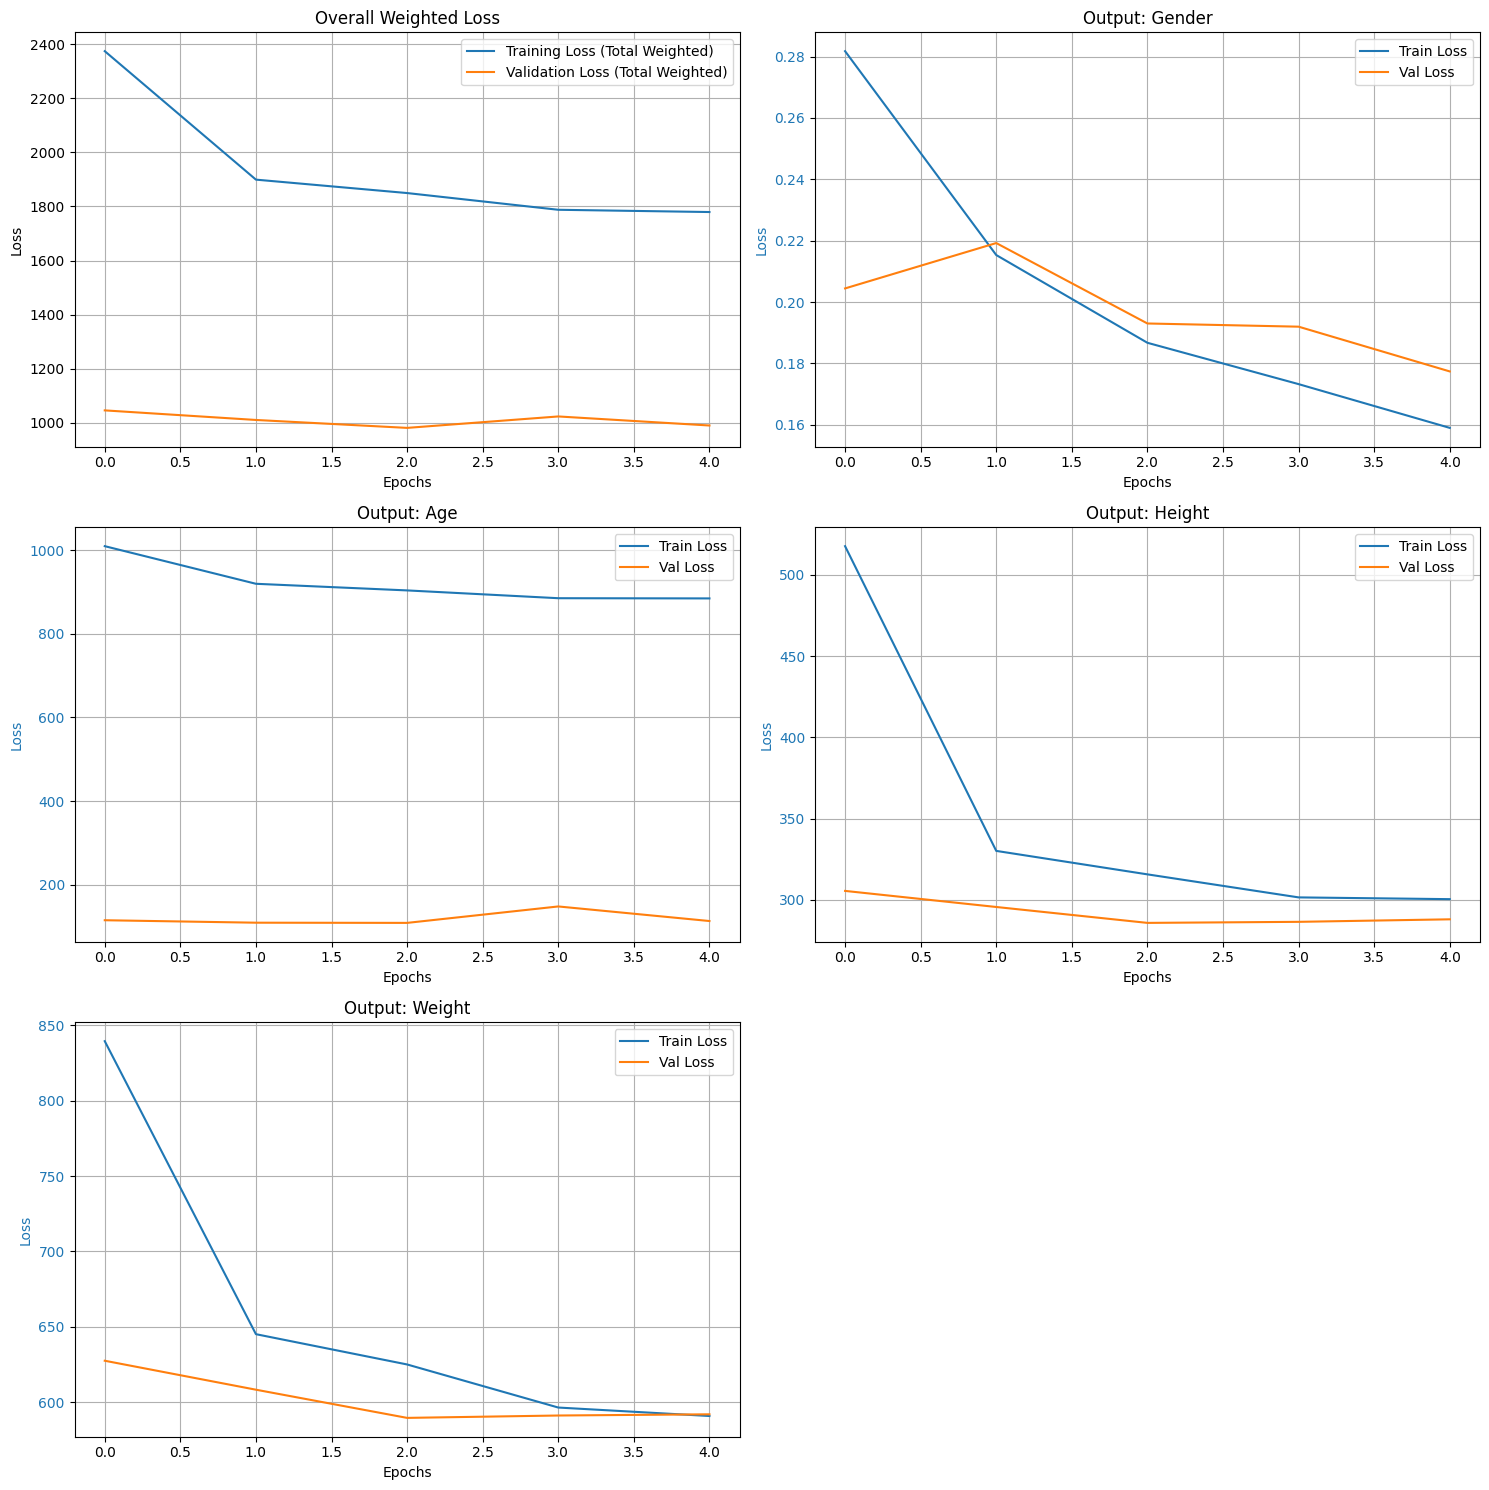

------------------------------


In [13]:
# @title 8. Train the Multi-Output Model (Save as .h5)

import pandas as pd # Make sure pandas is imported for history plotting

# --- Callbacks ---
# Monitor the overall validation loss ('val_loss') which is the weighted sum of individual losses
# Patience: Number of epochs with no improvement after which training stops.
# Restore Best Weights: Loads weights from the epoch with the best monitored value.
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor the total validation loss
    patience=8,         # Increased patience slightly
    restore_best_weights=True,
    verbose=1
)

# Save the best model based on overall validation loss
# CHANGE the filename to indicate it's a multi-output model
model_checkpoint_path = '/content/drive/MyDrive/multi_output_demographics_model_best.h5' # <-- ADJUST PATH IF NEEDED
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_loss', # Monitor the total validation loss
    save_best_only=True,
    save_weights_only=False, # Save entire model (architecture, weights, optimizer state)
    verbose=1
)

# Optional: Reduce learning rate if plateauing
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2, # Reduce LR by factor of 5
#     patience=3,
#     min_lr=1e-6, # Minimum learning rate
#     verbose=1
# )

# --- Training ---
EPOCHS = 5 # Set a higher initial number; EarlyStopping will likely finish sooner

print("Starting multi-output model training...")

if train_ds is None or val_ds is None:
     print("ERROR: Training or validation dataset is not available. Cannot start training.")
else:
    # Check if model is defined
    if 'model' not in globals():
        print("ERROR: Model is not defined. Please run Cell 7 first.")
    else:
        history = model.fit(
            train_ds,
            epochs=EPOCHS,
            validation_data=val_ds,
            callbacks=[early_stopping, model_checkpoint] # Add reduce_lr here if using it
        )

        print("\nTraining finished.")

        # --- Plot Training History ---
        if history and hasattr(history, 'history') and history.history:
            print("Plotting training history...")
            history_df = pd.DataFrame(history.history)

            # Determine number of plots needed (overall loss + one per output)
            num_outputs = len(TARGET_COLUMNS) # Defined in Cell 6
            num_rows_plot = (num_outputs + 1 + 1) // 2 # Arrange plots in 2 columns
            plt.figure(figsize=(15, 5 * num_rows_plot)) # Adjust figure size

            plot_idx = 1

            # 1. Plot Overall Weighted Loss
            plt.subplot(num_rows_plot, 2, plot_idx)
            if 'loss' in history_df and 'val_loss' in history_df:
                plt.plot(history_df['loss'], label='Training Loss (Total Weighted)')
                plt.plot(history_df['val_loss'], label='Validation Loss (Total Weighted)')
                plt.title('Overall Weighted Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)
            else:
                plt.title("Overall Weighted Loss (Data Missing)")
            plot_idx += 1


            # 2. Plot Individual Output Loss and Metrics
            # Use metrics_dict from Cell 7 to find the metric name for each output
            for output_name in TARGET_COLUMNS.keys():
                 plt.subplot(num_rows_plot, 2, plot_idx)
                 loss_key = f'{output_name}_loss'
                 val_loss_key = f'val_{output_name}_loss'

                 if loss_key in history_df and val_loss_key in history_df:
                     # Plot Loss for this output on the primary y-axis
                     line1, = plt.plot(history_df[loss_key], label=f'Train Loss', color='tab:blue')
                     line2, = plt.plot(history_df[val_loss_key], label=f'Val Loss', color='tab:orange')
                     plt.ylabel('Loss', color='tab:blue')
                     plt.tick_params(axis='y', labelcolor='tab:blue')
                     plt.grid(True)
                     plot_handles = [line1, line2]
                     plot_labels = [line1.get_label(), line2.get_label()]

                     # Find the corresponding metric name (e.g., 'accuracy' or 'mae')
                     metric_name = metrics_dict.get(output_name, None)
                     if metric_name and hasattr(metric_name, 'name'):
                        metric_key_base = metric_name.name # e.g., 'accuracy' or 'mae'
                        metric_key = f'{output_name}_{metric_key_base}'
                        val_metric_key = f'val_{output_name}_{metric_key_base}'

                        if metric_key in history_df and val_metric_key in history_df:
                            # Plot Metric on secondary y-axis
                            ax2 = plt.gca().twinx() # Create secondary axis sharing x-axis
                            line3, = ax2.plot(history_df[metric_key], label=f'Train {metric_key_base.upper()}', linestyle='--', color='tab:green')
                            line4, = ax2.plot(history_df[val_metric_key], label=f'Val {metric_key_base.upper()}', linestyle='--', color='tab:red')
                            ax2.set_ylabel(f'Metric ({metric_key_base.upper()})', color='tab:green')
                            ax2.tick_params(axis='y', labelcolor='tab:green')
                            plot_handles.extend([line3, line4])
                            plot_labels.extend([line3.get_label(), line4.get_label()])
                        else:
                             print(f"Metric keys '{metric_key}' or '{val_metric_key}' not found in history.")

                     # Add combined legend and title
                     plt.legend(plot_handles, plot_labels, loc='best')
                     plt.title(f'Output: {output_name.capitalize()}')
                     plt.xlabel('Epochs')
                     plot_idx += 1
                 else:
                     print(f"Loss keys '{loss_key}' or '{val_loss_key}' not found in history for output '{output_name}'. Skipping plot.")
                     # Add a placeholder plot if keys missing
                     plt.subplot(num_rows_plot, 2, plot_idx)
                     plt.title(f"Output: {output_name.capitalize()} (Data Missing)")
                     plt.xlabel('Epochs')
                     plot_idx += 1


            plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
            plt.show()
        else:
            print("No training history available to plot.")

print("-" * 30)

Attempting to load best multi-output model from: /content/drive/MyDrive/multi_output_demographics_model_best.h5


Best multi-output model loaded successfully.

Evaluating loaded multi-output model on the test set...
34/34 ━━━━━━━━━━━━━━━━━━━━ 218s 6s/step - age_loss: 112.5822 - age_mae: 7.7951 - gender_accuracy: 0.9398 - gender_loss: 0.1681 - height_loss: 291.3391 - height_mae: 9.8590 - loss: 999.3144 - weight_loss: 595.2623 - weight_mae: 17.2048

Test Set Evaluation Results (Metrics):
- Total Weighted Loss: 1043.2367
- compile_metrics: 0.1908 (Output name not parsed)
  Output 'gender':
    - gender_loss: 117.5946
  Output 'age':
    - age_loss: 301.0814
  Output 'height':
    - height_loss: 625.0211
  Output 'weight':
    - weight_loss: 8.0319

Generating detailed analysis for each output...
Gathering predictions and true labels from test set...
34/34 ━━━━━━━━━━━━━━━━━━━━ 213s 6s/step


Extracting True Labels:   0%|          | 0/1080 [00:00<?, ?it/s]


--- Analysis for Output: Gender (classification) ---

Classification Report:
              precision    recall  f1-score   support

      female       0.93      0.96      0.95       656
        male       0.94      0.89      0.91       424

    accuracy                           0.93      1080
   macro avg       0.93      0.93      0.93      1080
weighted avg       0.93      0.93      0.93      1080


Confusion Matrix:


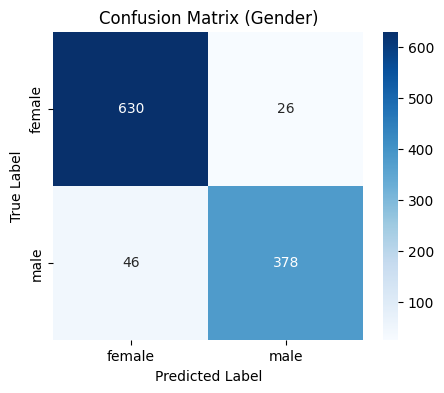


--- Analysis for Output: Age (regression) ---

Mean Absolute Error (MAE): 8.0319


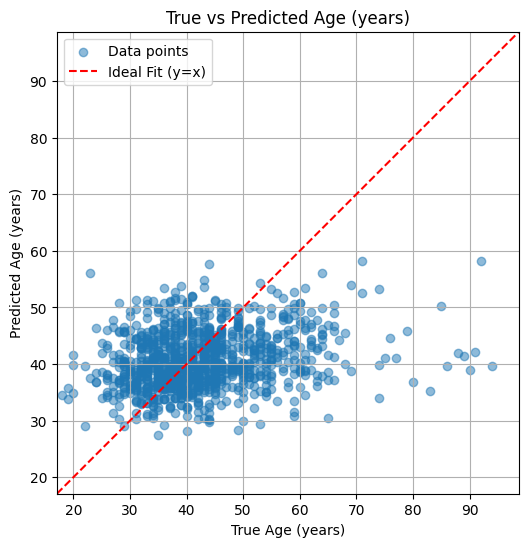


--- Analysis for Output: Height (regression) ---

Mean Absolute Error (MAE): 10.0359


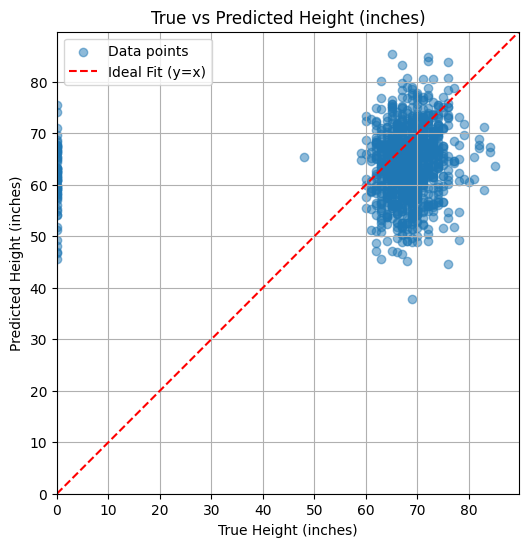


--- Analysis for Output: Weight (regression) ---

Mean Absolute Error (MAE): 17.4165


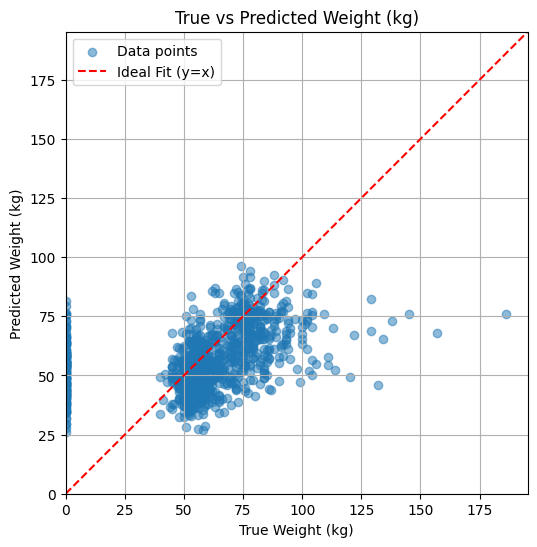

------------------------------


In [14]:
# @title 9. Evaluate the Multi-Output Model on Test Set

# Import necessary metrics functions
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import pandas as pd # Ensure pandas is available
import seaborn as sns # Ensure seaborn is available for heatmap
import matplotlib.pyplot as plt # Ensure matplotlib is available

# --- Define the path to the BEST MULTI-OUTPUT model saved by ModelCheckpoint ---
model_path_to_load = model_checkpoint_path # Use the variable from Cell 8
# Or specify directly if running separately:
# model_path_to_load = '/content/drive/MyDrive/multi_output_demographics_model_best.h5'

print(f"Attempting to load best multi-output model from: {model_path_to_load}")

# --- Load the Saved Model ---
loaded_model = None # Initialize to None
if not os.path.exists(model_path_to_load):
     print(f"ERROR: Model file not found at '{model_path_to_load}'.")
else:
    try:
        # No custom_objects needed if using standard layers/losses/metrics
        loaded_model = keras.models.load_model(model_path_to_load)
        print("Best multi-output model loaded successfully.")
        # loaded_model.summary() # Optional summary verification
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        # Optional: Print more detailed traceback for debugging
        # import traceback
        # traceback.print_exc()


# --- Ensure Test Dataset and Model are Available ---
if 'test_ds' not in globals() or test_ds is None:
    print("\nERROR: Test dataset ('test_ds') not found or is not properly defined.")
    can_evaluate = False
elif loaded_model is None:
     print("\nERROR: Model could not be loaded. Cannot proceed with evaluation.")
     can_evaluate = False
else:
     # Check if test_ds has data (sometimes it might be created but empty if errors occurred)
     try:
        # Try to take one element to see if it's valid
        _ = next(iter(test_ds))
        can_evaluate = True
     except StopIteration:
        print("\nERROR: Test dataset ('test_ds') is empty. Cannot evaluate.")
        can_evaluate = False
     except Exception as e:
        print(f"\nERROR: Could not iterate through test dataset: {e}")
        can_evaluate = False


# --- Evaluate on Test Set ---
if can_evaluate:
    print("\nEvaluating loaded multi-output model on the test set...")
    # model.evaluate() returns the total loss first, then individual losses & metrics
    # in the order they were specified during model.compile()
    results = loaded_model.evaluate(test_ds, verbose=1)

    print("\nTest Set Evaluation Results (Metrics):")
    if hasattr(loaded_model, 'metrics_names'):
        # Display metrics clearly associated with their output head
        metrics_summary = {}
        for name, value in zip(loaded_model.metrics_names, results):
            if name == 'loss': # Skip the total weighted loss here, focus on per-output metrics
                 print(f"- Total Weighted Loss: {value:.4f}")
                 continue

            # Try to parse output name from metric name (e.g., 'gender_accuracy')
            output_name_guess = name.split('_')[0] # Simple split, might need adjustment if names are complex
            if output_name_guess in TARGET_COLUMNS: # Check if it matches one of our targets
                if output_name_guess not in metrics_summary:
                    metrics_summary[output_name_guess] = []
                metrics_summary[output_name_guess].append(f"{name}: {value:.4f}")
            else: # If parsing fails, just print it
                 print(f"- {name}: {value:.4f} (Output name not parsed)")

        # Print the grouped metrics
        for output_name, metrics_list in metrics_summary.items():
             print(f"  Output '{output_name}':")
             for metric_str in metrics_list:
                 print(f"    - {metric_str}")

    else:
        print("Could not retrieve metric names from the loaded model.")
        print(f"Raw results array: {results}")


    # --- Detailed Analysis per Output ---
    print("\nGenerating detailed analysis for each output...")

    # 1. Get Predictions and True Labels
    y_pred_dict = {}
    y_true_dict = {key: [] for key in TARGET_COLUMNS.keys()} # Use keys from Cell 6 config

    print("Gathering predictions and true labels from test set...")
    # Predict returns a dictionary matching the model's output structure
    # Use verbose=1 for progress if the test set is large
    predictions_raw = loaded_model.predict(test_ds, verbose=1)

    # Iterate through the test dataset *once* to get true labels
    # unbatch(): Converts batched dataset back to individual elements
    # as_numpy_iterator(): Makes it easier to work with numpy arrays
    num_test_samples = len(test_df) # Get expected number of samples from the dataframe
    for _, labels_batch in tqdm(test_ds.unbatch().as_numpy_iterator(), total=num_test_samples, desc="Extracting True Labels"):
         for key in TARGET_COLUMNS.keys():
             # Append the label for the current sample to the list for that key
             # Ensure the key exists in the labels dictionary from the dataset
             if key in labels_batch:
                 y_true_dict[key].append(labels_batch[key])
             else:
                  print(f"Warning: Key '{key}' not found in dataset labels batch. Check dataset creation.")
                  # Append a placeholder if missing, though this indicates an issue
                  y_true_dict[key].append(np.nan)


    # Convert true label lists to numpy arrays
    for key in TARGET_COLUMNS.keys():
        y_true_dict[key] = np.array(y_true_dict[key])

    # Process predictions dictionary (predictions_raw should already be numpy arrays)
    y_pred_dict = predictions_raw # Keras predict usually returns numpy arrays in the dict


    # 2. Analyze Each Output
    for output_name, task_type in TARGET_COLUMNS.items():
        print(f"\n--- Analysis for Output: {output_name.capitalize()} ({task_type}) ---")

        # Ensure predictions and true labels exist and are not empty for this output
        if output_name not in y_pred_dict or output_name not in y_true_dict:
             print(f"Skipping analysis for {output_name}: Prediction or True Label data missing.")
             continue
        if len(y_pred_dict[output_name]) == 0 or len(y_true_dict[output_name]) == 0:
            print(f"Skipping analysis for {output_name}: Data array is empty.")
            continue

        y_pred_out = y_pred_dict[output_name].flatten() # Flatten predictions for this output
        y_true_out = y_true_dict[output_name].flatten() # Flatten true labels

        # Ensure consistent lengths (should match if extraction was correct)
        if len(y_pred_out) != len(y_true_out):
            print(f"Warning: Mismatch in length for {output_name} (Pred: {len(y_pred_out)}, True: {len(y_true_out)}). Check data extraction.")
            min_len = min(len(y_pred_out), len(y_true_out))
            y_pred_out = y_pred_out[:min_len]
            y_true_out = y_true_out[:min_len]

        # Remove NaN values if any placeholders were added (indicates prior error)
        valid_indices = ~np.isnan(y_true_out)
        if np.sum(~valid_indices) > 0:
            print(f"Warning: Removing {np.sum(~valid_indices)} NaN entries for {output_name}.")
        y_pred_out = y_pred_out[valid_indices]
        y_true_out = y_true_out[valid_indices]

        if len(y_true_out) == 0:
            print(f"Skipping analysis for {output_name}: No valid data points after NaN removal.")
            continue


        if task_type == 'classification':
            # Convert probabilities to class labels (0 or 1 for binary sigmoid output)
            threshold = 0.5
            y_pred_classes = (y_pred_out > threshold).astype(int)
            y_true_int = y_true_out.astype(int) # Ensure true labels are integers for classification metrics

            # Use class names defined in Cell 6 if available (specifically for gender)
            target_names_cls = class_names if output_name == GENDER_TARGET_COL else ['Class 0', 'Class 1']

            # Classification Report
            print("\nClassification Report:")
            # Handle potential errors if only one class present in true or predicted labels after filtering
            try:
                report = classification_report(y_true_int, y_pred_classes, target_names=target_names_cls, zero_division=0)
                print(report)
            except ValueError as e:
                print(f"Could not generate classification report: {e}")
                print(f"Unique true labels found: {np.unique(y_true_int)}")
                print(f"Unique predicted labels found: {np.unique(y_pred_classes)}")

            # Confusion Matrix
            print("\nConfusion Matrix:")
            try:
                cm = confusion_matrix(y_true_int, y_pred_classes)
                plt.figure(figsize=(5, 4))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=target_names_cls, yticklabels=target_names_cls)
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.title(f'Confusion Matrix ({output_name.capitalize()})')
                plt.show()
            except ValueError as e:
                 print(f"Could not generate confusion matrix: {e}")


        elif task_type == 'regression':
            # Calculate MAE (confirms the metric from model.evaluate)
            mae = mean_absolute_error(y_true_out, y_pred_out)
            print(f"\nMean Absolute Error (MAE): {mae:.4f}")

            # Determine appropriate unit for plot titles/labels
            unit = ""
            if output_name == 'age': unit = "years"
            elif output_name == 'height': unit = "inches"
            elif output_name == 'weight': unit = "kg"

            # Scatter plot of True vs Predicted
            plt.figure(figsize=(6, 6))
            plt.scatter(y_true_out, y_pred_out, alpha=0.5, label="Data points")
            # Add line y=x for reference
            plot_min = min(min(y_true_out), min(y_pred_out)) * 0.95
            plot_max = max(max(y_true_out), max(y_pred_out)) * 1.05
            plt.plot([plot_min, plot_max], [plot_min, plot_max], '--', color='red', label='Ideal Fit (y=x)')
            plt.title(f'True vs Predicted {output_name.capitalize()} ({unit})')
            plt.xlabel(f'True {output_name.capitalize()} ({unit})')
            plt.ylabel(f'Predicted {output_name.capitalize()} ({unit})')
            plt.grid(True)
            plt.legend()
            plt.xlim(plot_min, plot_max)
            plt.ylim(plot_min, plot_max)
            plt.gca().set_aspect('equal', adjustable='box') # Make axes equal scale
            plt.show()

            # Optional: Residual Plot (Difference between true and predicted)
            # residuals = y_true_out - y_pred_out
            # plt.figure(figsize=(7, 4))
            # plt.scatter(y_pred_out, residuals, alpha=0.5)
            # plt.hlines(0, xmin=min(y_pred_out), xmax=max(y_pred_out), colors='red', linestyles='--', label='Zero Residual')
            # plt.title(f'Residual Plot ({output_name.capitalize()})')
            # plt.xlabel(f'Predicted {output_name.capitalize()} ({unit})')
            # plt.ylabel('Residual (True - Predicted)')
            # plt.grid(True)
            # plt.legend()
            # plt.show()

else:
    print("\nEvaluation skipped due to model loading failure or missing/invalid test data.")

print("-" * 30)

Loading multi-output model for prediction from: /content/drive/MyDrive/multi_output_demographics_model_best.h5


Multi-output model loaded successfully for prediction.

Selecting random sample from the test set (1080 images)...
Selected Image: 1056_5.9h_54w_female_33a.png
True Values : Gender=Female, Age=33y, Height=69", Weight=54kg

Making predictions using the multi-output model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
- Predicted Gender: Female (0.00 conf)
- Predicted Age: 35.5 years
- Predicted Height: 66.6 inches
- Predicted Weight: 53.6 kg


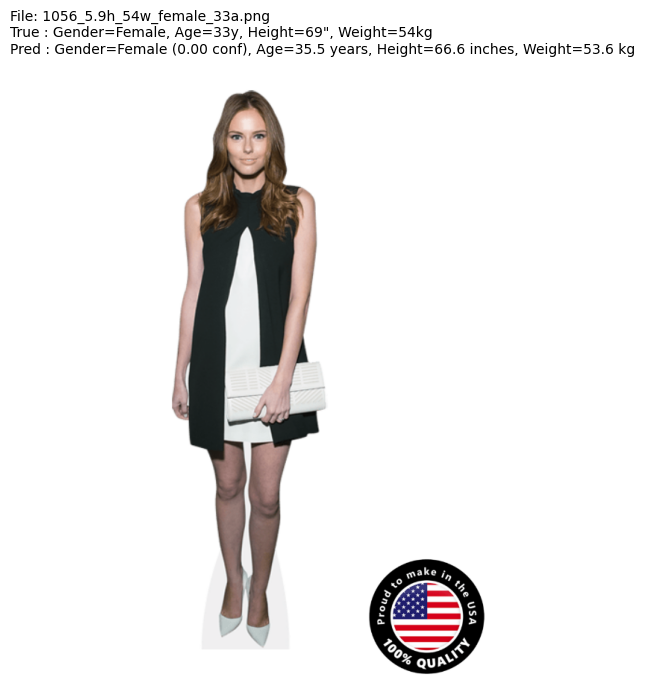

------------------------------
Cell 10 Finished.


In [19]:
# @title 10. Predict All Demographics for a Random Sample (Using Multi-Output Model)

import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input # Ensure this matches training
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- Configuration ---
IMG_SIZE = (224, 224) # Must match the training IMG_SIZE

# --- IMPORTANT: Load the SINGLE multi-output model ---
# Use the variable holding the path to the *best* saved model from Cell 8/9
# This ensures we use the model that performed best on validation data
model_path_to_load = model_checkpoint_path
# Or specify directly if running Cell 10 in a new session after training:
# model_path_to_load = '/content/drive/MyDrive/multi_output_demographics_model_best.h5'

# Get class names for gender from Cell 6 if available, otherwise provide defaults
CLASS_NAMES_GENDER = class_names if 'class_names' in globals() else ['Female', 'Male'] # Use names from Cell 6 if they exist

# Get the label map from Cell 6 if available, otherwise define reasonable defaults
LABEL_COLUMN_MAP_PREDICT = LABEL_COLUMN_MAP if 'LABEL_COLUMN_MAP' in globals() else {
    'gender': 'gender',
    'age': 'age_years',
    'height': 'height_inches',
    'weight': 'weight_kg'
}


# --- Function to Load and Preprocess a Single Image ---
# (Using the same function structure as before)
def load_and_preprocess_single_image(img_path, target_size):
    """Loads image from path, preprocesses for ResNet50."""
    try:
        img = Image.open(img_path).convert('RGB') # Ensure 3 channels
        # Use LANCZOS resampling for potentially better quality resize
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        img_array = image.img_to_array(img)
        # Add batch dimension: (height, width, channels) -> (1, height, width, channels)
        img_expanded = np.expand_dims(img_array, axis=0)
        # Preprocess using the same function as during training
        img_preprocessed = preprocess_input(img_expanded)
        return img_preprocessed
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}")
        return None
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# --- Load the Multi-Output Model ---
print(f"Loading multi-output model for prediction from: {model_path_to_load}")
predict_model = None # Initialize to None
if not os.path.exists(model_path_to_load):
    print(f"ERROR: Model file not found at '{model_path_to_load}'. Make sure Cell 8 ran successfully and saved the model.")
else:
    try:
        # Load the model saved in Cell 8/9
        predict_model = load_model(model_path_to_load)
        print("Multi-output model loaded successfully for prediction.")
    except Exception as e:
        print(f"ERROR loading model from {model_path_to_load}: {e}")

# --- Proceed only if model and test data exist ---
if 'test_df' not in globals() or test_df.empty:
    print("\nERROR: 'test_df' DataFrame not found or is empty. Please run Cell 6 first.")
elif predict_model is None:
     print("\nERROR: Multi-output model could not be loaded. Cannot proceed with prediction.")
else:
    print(f"\nSelecting random sample from the test set ({len(test_df)} images)...")
    try:
        # Select a random row from the test dataframe
        sample_row = test_df.sample(1).iloc[0]
        img_path = sample_row['filepath']

        # Get true values using the column names from the map used in Cell 6
        # Use .get() with a default in case a column was missing in the original parse/df
        true_gender = sample_row.get(LABEL_COLUMN_MAP_PREDICT['gender'], 'N/A')
        true_age = sample_row.get(LABEL_COLUMN_MAP_PREDICT['age'], 'N/A')
        true_height = sample_row.get(LABEL_COLUMN_MAP_PREDICT['height'], 'N/A')
        true_weight = sample_row.get(LABEL_COLUMN_MAP_PREDICT['weight'], 'N/A')

        print(f"Selected Image: {os.path.basename(img_path)}")
        # Ensure true_gender is capitalized correctly even if it was already encoded
        true_gender_display = str(true_gender).capitalize()
        if isinstance(true_gender, (int, float)): # Handle if it's the encoded 0/1 value
             try:
                 true_gender_display = CLASS_NAMES_GENDER[int(true_gender)].capitalize()
             except (IndexError, TypeError):
                 true_gender_display = f"Encoded({true_gender})" # Fallback if encoding issue


        print(f"True Values : Gender={true_gender_display}, Age={true_age}y, Height={true_height}\", Weight={true_weight}kg")

        # Load and preprocess the image
        processed_img = load_and_preprocess_single_image(img_path, IMG_SIZE)

        if processed_img is not None:
            # --- Make Predictions ---
            predictions_display = {} # Store formatted predictions for display
            print("\nMaking predictions using the multi-output model...")

            # model.predict() returns a dictionary with keys matching output layer names
            pred_dict_raw = predict_model.predict(processed_img)

            # --- Extract and Format Predictions ---
            # Gender
            output_name = 'gender'
            if output_name in pred_dict_raw:
                 pred_prob_gender = pred_dict_raw[output_name][0][0] # Probability of class 1
                 pred_gender_idx = int(pred_prob_gender > 0.5)
                 # Handle case where index might be out of bounds if CLASS_NAMES_GENDER is wrong
                 pred_gender = CLASS_NAMES_GENDER[pred_gender_idx] if pred_gender_idx < len(CLASS_NAMES_GENDER) else f"Class_{pred_gender_idx}"
                 predictions_display[output_name] = f"{pred_gender.capitalize()} ({pred_prob_gender:.2f} conf)"
                 print(f"- Predicted Gender: {predictions_display[output_name]}")
            else:
                 predictions_display[output_name] = "N/A (Output missing)"
                 print(f"- Predicted Gender: {predictions_display[output_name]}")

            # Age
            output_name = 'age'
            if output_name in pred_dict_raw:
                 pred_age = pred_dict_raw[output_name][0][0]
                 predictions_display[output_name] = f"{pred_age:.1f} years"
                 print(f"- Predicted Age: {predictions_display[output_name]}")
            else:
                 predictions_display[output_name] = "N/A (Output missing)"
                 print(f"- Predicted Age: {predictions_display[output_name]}")

            # Height
            output_name = 'height'
            if output_name in pred_dict_raw:
                 pred_height = pred_dict_raw[output_name][0][0]
                 predictions_display[output_name] = f"{pred_height:.1f} inches"
                 print(f"- Predicted Height: {predictions_display[output_name]}")
            else:
                 predictions_display[output_name] = "N/A (Output missing)"
                 print(f"- Predicted Height: {predictions_display[output_name]}")


            # Weight
            output_name = 'weight'
            if output_name in pred_dict_raw:
                 pred_weight = pred_dict_raw[output_name][0][0]
                 predictions_display[output_name] = f"{pred_weight:.1f} kg"
                 print(f"- Predicted Weight: {predictions_display[output_name]}")
            else:
                 predictions_display[output_name] = "N/A (Output missing)"
                 print(f"- Predicted Weight: {predictions_display[output_name]}")


            # --- Display Image and Results ---
            display_img = Image.open(img_path)
            plt.figure(figsize=(10, 7)) # Slightly larger figure
            plt.imshow(display_img)

            # Construct title string dynamically based on available predictions
            pred_str = ", ".join([f"{k.capitalize()}={v}" for k,v in predictions_display.items() if v != "N/A (Output missing)"]) # Only include successful predictions
            title_text = (
                f"File: {os.path.basename(img_path)}\n"
                f"True : Gender={true_gender_display}, Age={true_age}y, Height={true_height}\", Weight={true_weight}kg\n"
                f"Pred : {pred_str}"
            )
            plt.title(title_text, fontsize=10, loc='left') # Align title left for readability
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        else:
            print("Skipping prediction due to image processing error.")

    except KeyError as e:
         print(f"\nKeyError during prediction/display: {e}")
         print("This might indicate a mismatch between expected output names/dataframe columns and actual data.")
         print("Check TARGET_COLUMNS, LABEL_COLUMN_MAP in Cell 6, and the model's output layer names.")
    except Exception as e:
        print(f"An error occurred during the sampling or prediction process: {e}")
        import traceback
        traceback.print_exc() # Print detailed error traceback for debugging

print("-" * 30)
print("Cell 10 Finished.")